In [1]:
%matplotlib inline
import pathlib
from glob import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def read_time_series(path):
    df = pd.read_csv(path)
    df.index = df.time
    df = df[['area']]
    
    return df

In [3]:
out_dir_monthly_timeseries_by_gadm2 = pathlib.Path('../data/wps-reservoir-time-series-latest/time_series_area_by_gadm2/')
out_dir_monthly_timeseries_by_gadm2.mkdir(exist_ok=True)

In [4]:
dir_monthly_timeseries = '../data/wps-reservoir-time-series-latest/time_series_area_monthly/'

In [5]:
reservoirs_and_gadm2 = gpd.read_file(r'../data/shp/reservoirs-v1.0-and-gadm2.shp')

In [6]:
reservoirs_and_gadm2.fid = reservoirs_and_gadm2.fid.astype(int)

In [7]:
reservoirs_and_gadm2[['fid', 'GID_2']]

,fid,GID_2
0,87986,AFG.11.4_1
1,80316,AFG.12.2_1
2,2192,AFG.12.4_1
3,65733,AFG.14.11_1
4,85529,AFG.14.14_1
...,...,...
79534,76411,ZWE.9.7_1
79535,78441,ZWE.9.7_1
79536,60506,None
79537,77440,None


In [8]:
reservoirs_and_gadm2[['fid', 'GID_2']].to_csv(out_dir_monthly_timeseries_by_gadm2 / 'reservoirid_gadm2_mapping.csv', index=False)

In [9]:
def compute_aggreated_timeseries(gadm2_id):
    reservoir_ids = reservoirs_and_gadm2[reservoirs_and_gadm2.GID_2 == gadm2_id].fid.values    
    filenames = [f'{str(fid).zfill(7)}.csv' for fid in reservoir_ids]

    dfs = []
    for f in filenames:
        path = pathlib.Path(dir_monthly_timeseries) / f
        
        if not path.exists():
            print(f'Warning, time series does not exist: {path.name}')
            continue
        
        dfs.append(read_time_series(path))
        
    if len(dfs) == 0:
        return
        
    df = dfs[0]
    for i, df_ in enumerate(dfs[1:]):
        df = df.join(df_, how='outer', rsuffix=f'_{i}')
    
    df['area'] = df.sum(axis=1)
    df = df[['area']]
    df.to_csv(out_dir_monthly_timeseries_by_gadm2 / f'{gadm2_id}.csv')

In [10]:
gadm2_areas = reservoirs_and_gadm2.GID_2.unique()

for i in tqdm(gadm2_areas):
    compute_aggreated_timeseries(i)

Warning, time series does not exist: 0035618.csv



In [11]:
compute_aggreated_timeseries('PRK.3.7_1')

In [12]:
reservoir_ids = reservoirs_and_gadm2[reservoirs_and_gadm2.GID_2 == 'PRK.3.7_1'].fid.values
reservoir_ids

array([33154, 42305, 42642])

In [13]:
filenames = [f'{str(fid).zfill(7)}.csv' for fid in reservoir_ids]
filenames

['0033154.csv', '0042305.csv', '0042642.csv']

In [14]:
dfs = []
for f in filenames:
    path = pathlib.Path(dir_monthly_timeseries) / f
    dfs.append(read_time_series(path))

In [15]:
df = dfs[0]
for i, df_ in enumerate(dfs[1:]):
    df = df.join(df_, how='outer', rsuffix=f'_{i}')

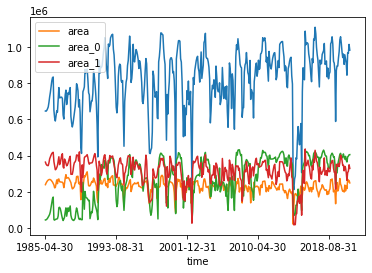

In [16]:
fig, ax = plt.subplots(1, 1)
df.sum(axis=1).plot(ax=ax)
df.plot(ax=ax)

In [17]:
df

,area,area_0,area_1
time,,,
1985-04-30,239163.483881,43776.246536,363793.896198
1985-05-31,248218.860104,44971.748637,352711.762373
1985-06-30,255326.369890,48179.330350,347178.165959
1985-07-31,260991.850232,53260.756086,345042.627438
1985-08-31,264983.388068,59780.226353,344737.550506
...,...,...,...
2020-10-31,217268.325283,364691.153310,263158.695798
2020-11-30,268902.106534,392880.723762,306353.924487
2020-12-31,255318.432055,397383.018232,313321.056827
